In [3]:
import pandas as pd
import numpy as np


from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn import svm

from scipy import interp
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import  TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

In [5]:
os.chdir(r'C:\Folder')

NameError: name 'os' is not defined

In [4]:
df_clean = pd.read_csv('Amazon_mobile_cleannn.csv')
df_clean.head()


FileNotFoundError: [Errno 2] No such file or directory: 'Amazon_mobile_cleannn.csv'

In [28]:
df_clean.describe()

NameError: name 'df_clean' is not defined

In [4]:
df_clean['flesch_reading_ease'].describe()

count    104847.000000
mean         42.553339
std          54.387987
min       -1293.710000
25%          27.490000
50%          49.820000
75%          69.790000
max         206.840000
Name: flesch_reading_ease, dtype: float64

In [4]:
df_clean['s_word_count'].describe()

count    104847.000000
mean          2.693143
std           1.666288
min           0.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          20.000000
Name: s_word_count, dtype: float64

Text(0, 0.5, 'Frequency')

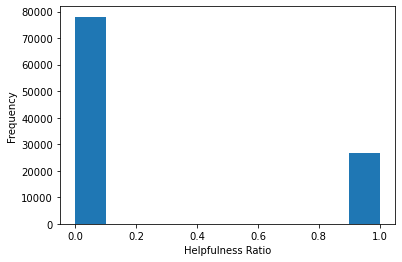

In [5]:
# From this Hist we see that our target column is not balance
import matplotlib.pyplot as plt 

plt.hist(df_clean['helpfulness'])
plt.xlabel('Helpfulness Ratio')
plt.ylabel('Frequency')

In [6]:
# Helpfulness column
# Class 1 26793, class 0 78056
df_clean['helpfulness'].value_counts()

0    78054
1    26793
Name: helpfulness, dtype: int64

In [7]:
#Shape of our cleaned data
df_clean.shape

(104847, 26)

##### TFIDF(Term Frequency — Inverse Document Frequency)
###### This method is a widely used technique in Information Retrieval and Text Mining
###### With the use of this we are able to compute a weight to each word which signifies the importance of the word in the document 
###### We are splitting as bigram (2,2) and considered their combined weight. Here we are taking only the top 10,000 words from the reviewbody.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=10000,ngram_range=(2,2))
# TF-IDF feature matrix
tfidf_idf = tfidf_vectorizer.fit_transform(df_clean['review_body'].values.astype('str'))

In [9]:
tfidf_idf


<104847x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 717445 stored elements in Compressed Sparse Row format>

In [10]:
# Here we are using all the features except the helpfulness ratio which is the target column for our model

from scipy.sparse import hstack, csr_matrix

meta_features = [
'star_rating',
'vine',
'verified_purchase',
'subjectivity',
'polarity',
's_subjectivity',
's_polarity',
'sentiment',
's_sentiment',
'character_count',
'word_count',
's_word_count',
'unique_word_count',
'syllable_count',
'flesch_reading_ease',
'flesch_kincaid_grade',
'automated_readability_index',
'coleman_liau_index',
'linsear_write_formula',
'dale_chall_readability_score',
'noun_count',
'verb_count',
'adv_count',
'adj_count']

feature_set1 = df_clean[meta_features]

train = hstack([tfidf_idf, csr_matrix(feature_set1)], "csr")
train

<104847x10024 sparse matrix of type '<class 'numpy.float64'>'
	with 2940202 stored elements in Compressed Sparse Row format>

In [11]:
#Defining our target column
target = df_clean['helpfulness'].values

In [12]:
target

array([0, 0, 0, ..., 1, 1, 1])

In [13]:
# Defining the X
X = train
## defining the target columns
y = target

In [14]:
y.shape

(104847,)

In [15]:
X.shape

(104847, 10024)

##### SMOTE Techniques to balance imbalance data

In [16]:
# As we have noticed that the class 0 is over class 1 by great margine, 
# So we applied the the SMOTE Techniques(Synthetic Minority Oversampling Technique) 
# To balance out the imbalanced dataset problem. It aims to balance class distribution 
# By randomly increasing minority class 

print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state=130)
X_res, y_res = smote.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({0: 78054, 1: 26793})
Resampled dataset shape Counter({0: 78054, 1: 78054})


##### Applying the Train Test split

In [17]:
## Here we are spliting the data into 75 / 25 respectively
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.25, random_state=0)

In [18]:
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold

# predictions = model.predict(X_test)
# cv = RepeatedStratifiedKFold(n_splits=10, random_state=7, n_repeats=3)
# model = LogisticRegression(solver='liblinear')
# scoring = 'accuracy'
# results = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
# print("\nAccuracy:", accuracy_score(y_test, predictions))

##### ROC / AUC Function for evalution

In [22]:
def evbiclas(model,cr=0):
  preds = model.predict(X_test)
  print('\n'+'\033[1m'+type(model).__name__+'\033[0;0m')    
  print("----------------------------------")
  print("\nTrain Accuracy:","{:.2f}".format(model.score(X_train, y_train)*100))

  print("\nTest Accuracy:", "{:.2f}".format(model.score(X_test, y_test)*100))

  print("\nClassification report:")
  print(classification_report(preds, y_test))

  print("\nConfusion matrix:")
  # Creating the confusion matrix
  cm = confusion_matrix(preds, y_test)
  # Assigning columns names
  cm_df = pd.DataFrame(cm, 
              columns = ['Predicted Positive','Predicted Negative'],
              index = [ 'Actual Positive','Actual Negative'])
  print(cm_df)
  print("----------------------------------")
  sensitivity1 = cm[0,0]/(cm[0,0]+cm[0,1])
  print('\nSensitivity : ',"{:.2f}".format(sensitivity1*100))

  specificity1 = cm[1,1]/(cm[1,0]+cm[1,1])
  print('Specificity : ', "{:.2f}".format(specificity1*100))
  print("\nROC / AUC:")


  probabilities = model.predict_proba(X_test)
  probabilities = probabilities[:, 1]  # keep probabilities for first class only
        
  # Compute the ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, probabilities)    
  plt.figure(figsize = (10,7))
  plt.title(f"ROC Curve with AUC = {str(round(roc_auc_score(y_test, probabilities),3))}", fontsize=22)
  # Plot the "dumb model" line
  plt.plot([0, 1], [0, 1], linestyle='--',label='baseline')
    
  # Plot the model line
  plt.plot(fpr, tpr, marker='.',label='ROC Curve')
  plt.text(0.75, 0.25, "AUC: " + str(round(roc_auc_score(y_test, probabilities),3)),fontsize=18)
    
  plt.ylabel('Sensitivity', fontsize=18)
  plt.xlabel('1 - Specificity', fontsize=18)

  plt.legend(fontsize=16)
    
  # show the plot
  plt.show();




  print("\n----------------------------------")
  print("\nCross Validation 10K fold Result")
  print('\n')
  if type(cr)==int:
    print('\033[1m*Cross validation Result Not avaible*\033[0;0m')
  else:
    ud=1
    for i in cr:
      print('K',ud,':',"{:.2f}".format(i*100))
      ud=ud+1
  print("\n----------------------------------")
  print('The Model Parameters:','\n',model.get_params())

### Model Selection
##### LogisticRegression
###### Accuracy of 64.1%


LogisticRegression
----------------------------------

Train Accuracy: 64.11

Test Accuracy: 64.16

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.62      0.66     21536
           1       0.59      0.66      0.62     17491

    accuracy                           0.64     39027
   macro avg       0.64      0.64      0.64     39027
weighted avg       0.65      0.64      0.64     39027


Confusion matrix:
                 Predicted Positive  Predicted Negative
Actual Positive               13442                8094
Actual Negative                5894               11597
----------------------------------

Sensitivity :  62.42
Specificity :  66.30

ROC / AUC:


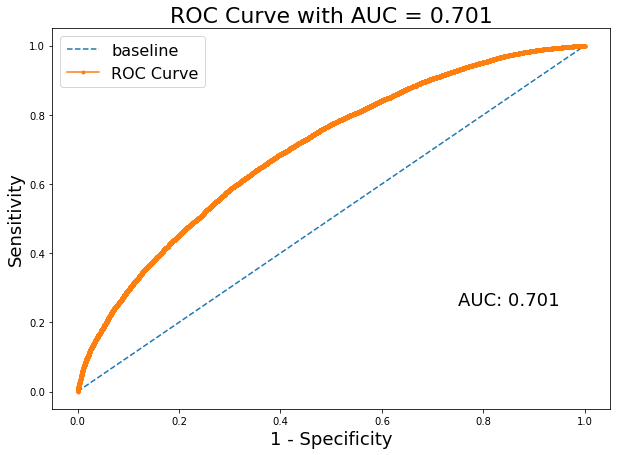


----------------------------------

Cross Validation 10K fold Result


*Cross validation Result Not avaible*

----------------------------------
The Model Parameters: 
 {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [56]:
model = LogisticRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)
evbiclas(model)

In [34]:
# import pickle
# X_OS=pickle.load(open('X_OS','rb'))
# y_OS=pickle.load(open('y_OS','rb'))

##### Naive Bayes(Multivariate Bernoulli) Classifier
###### Accuracy of 71.3%


BernoulliNB
----------------------------------

Train Accuracy: 71.77

Test Accuracy: 71.30

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.67      0.74     24585
           1       0.58      0.79      0.67     14442

    accuracy                           0.71     39027
   macro avg       0.71      0.73      0.71     39027
weighted avg       0.75      0.71      0.72     39027


Confusion matrix:
                 Predicted Positive  Predicted Negative
Actual Positive               16360                8225
Actual Negative                2976               11466
----------------------------------

Sensitivity :  66.54
Specificity :  79.39

ROC / AUC:


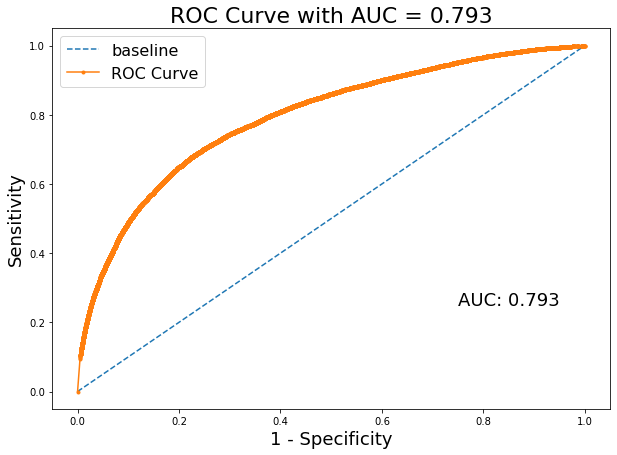


----------------------------------

Cross Validation 10K fold Result


*Cross validation Result Not avaible*

----------------------------------
The Model Parameters: 
 {'alpha': 1.0, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True}


In [57]:
model = BernoulliNB()
model.fit(X_train, y_train)
preds = model.predict(X_test)
evbiclas(model)

##### DecisionTree Classifier
###### Accuracy of 78.4%


DecisionTreeClassifier
----------------------------------

Train Accuracy: 99.81

Test Accuracy: 78.43

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79     20637
           1       0.75      0.81      0.78     18390

    accuracy                           0.78     39027
   macro avg       0.78      0.79      0.78     39027
weighted avg       0.79      0.78      0.78     39027


Confusion matrix:
                 Predicted Positive  Predicted Negative
Actual Positive               15778                4859
Actual Negative                3558               14832
----------------------------------

Sensitivity :  76.45
Specificity :  80.65

ROC / AUC:


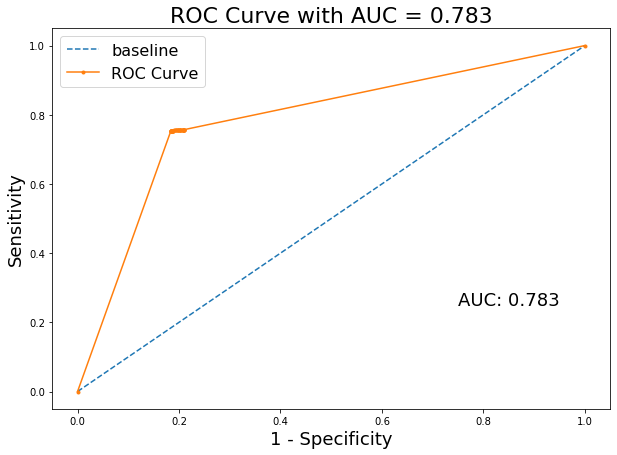


----------------------------------

Cross Validation 10K fold Result


*Cross validation Result Not avaible*

----------------------------------
The Model Parameters: 
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In [58]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
evbiclas(model)

##### RandomForest Classifier
###### Accuracy of 84.3%


RandomForestClassifier
----------------------------------

Train Accuracy: 99.81

Test Accuracy: 84.37

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85     21351
           1       0.79      0.88      0.84     17676

    accuracy                           0.84     39027
   macro avg       0.84      0.85      0.84     39027
weighted avg       0.85      0.84      0.84     39027


Confusion matrix:
                 Predicted Positive  Predicted Negative
Actual Positive               17293                4058
Actual Negative                2043               15633
----------------------------------

Sensitivity :  80.99
Specificity :  88.44

ROC / AUC:


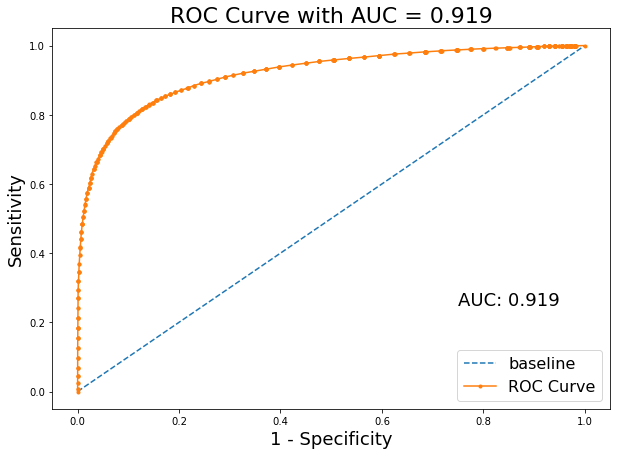


----------------------------------

Cross Validation 10K fold Result


*Cross validation Result Not avaible*

----------------------------------
The Model Parameters: 
 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [59]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
evbiclas(model)

##### XGB Classifier
###### Accuracy of 83.2%


XGBClassifier
----------------------------------

Train Accuracy: 84.76

Test Accuracy: 83.21

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.77      0.85     23863
           1       0.72      0.93      0.81     15164

    accuracy                           0.83     39027
   macro avg       0.83      0.85      0.83     39027
weighted avg       0.86      0.83      0.83     39027


Confusion matrix:
                 Predicted Positive  Predicted Negative
Actual Positive               18323                5540
Actual Negative                1013               14151
----------------------------------

Sensitivity :  76.78
Specificity :  93.32

ROC / AUC:


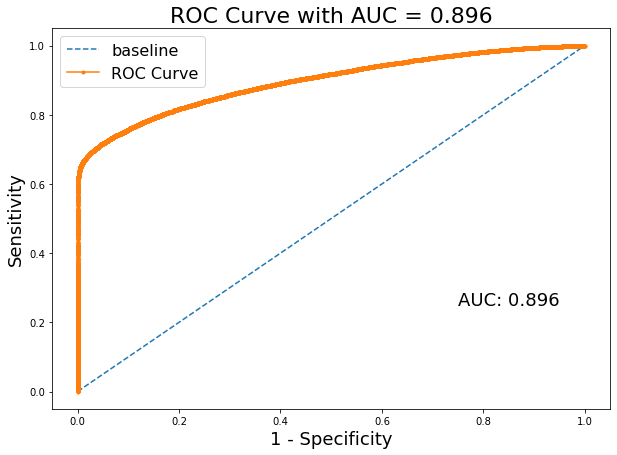


----------------------------------

Cross Validation 10K fold Result


*Cross validation Result Not avaible*

----------------------------------
The Model Parameters: 
 {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 1, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


In [60]:

from xgboost import XGBClassifier

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
evbiclas(model)

##### KNeighbors Classifier
###### Accuracy of 72%


KNeighborsClassifier
----------------------------------

Train Accuracy: 80.61

Test Accuracy: 72.06

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.83      0.66     12757
           1       0.89      0.67      0.76     26270

    accuracy                           0.72     39027
   macro avg       0.72      0.75      0.71     39027
weighted avg       0.78      0.72      0.73     39027


Confusion matrix:
                 Predicted Positive  Predicted Negative
Actual Positive               10594                2163
Actual Negative                8742               17528
----------------------------------

Sensitivity :  83.04
Specificity :  66.72

ROC / AUC:


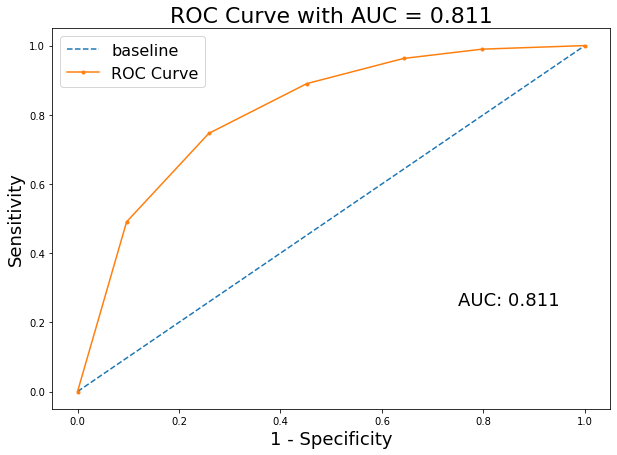


----------------------------------

Cross Validation 10K fold Result


*Cross validation Result Not avaible*

----------------------------------
The Model Parameters: 
 {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


In [62]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
evbiclas(model)

##### ExtraTrees Classifier
###### Accuracy of 87.0%


ExtraTreesClassifier
----------------------------------

Train Accuracy: 99.81

Test Accuracy: 87.03

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87     20396
           1       0.84      0.89      0.87     18631

    accuracy                           0.87     39027
   macro avg       0.87      0.87      0.87     39027
weighted avg       0.87      0.87      0.87     39027


Confusion matrix:
                 Predicted Positive  Predicted Negative
Actual Positive               17335                3061
Actual Negative                2001               16630
----------------------------------

Sensitivity :  84.99
Specificity :  89.26

ROC / AUC:


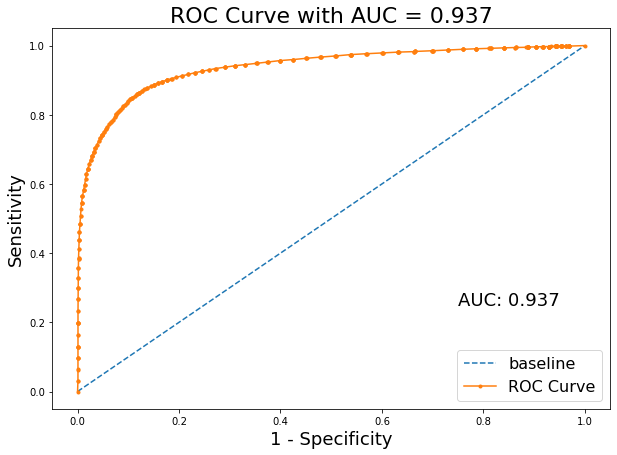


----------------------------------

Cross Validation 10K fold Result


*Cross validation Result Not avaible*

----------------------------------
The Model Parameters: 
 {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [61]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
evbiclas(model)

##### SVM Classifier
###### Accuracy of 63.2%


SVC
----------------------------------

Train Accuracy: 63.58

Test Accuracy: 63.21

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.61      0.66     22747
           1       0.55      0.66      0.60     16280

    accuracy                           0.63     39027
   macro avg       0.63      0.64      0.63     39027
weighted avg       0.65      0.63      0.63     39027


Confusion matrix:
                 Predicted Positive  Predicted Negative
Actual Positive               13863                8884
Actual Negative                5473               10807
----------------------------------

Sensitivity :  60.94
Specificity :  66.38

ROC / AUC:


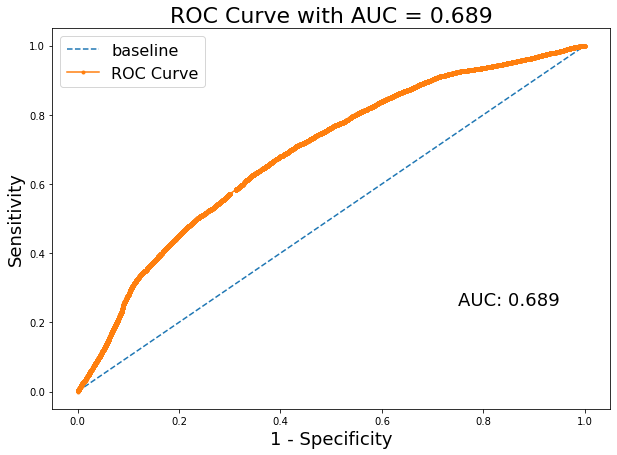


----------------------------------

Cross Validation 10K fold Result


*Cross validation Result Not avaible*

----------------------------------
The Model Parameters: 
 {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [23]:
model = svm.SVC(probability=True)
model.fit(X_train, y_train)
preds = model.predict(X_test)
evbiclas(model)

### As we can see, all our model performed great except for Logistic Regression and SVC below 70% Accuracy. Random Forest, XGB and ExtraTrees performed better and above 80% accuracy which is great. 